# Test reading SMAP L4 data

In [1]:
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

## Input data ver 1: pre-processed using NSIDC server

Data is pre-processed using https://github.com/nsidc/smap_python_notebooks/

In [2]:
input_path = r'..\1_data\SPL4SMGP'
fn_NSIDC_output = 'SMAP_L4_SM_gph_20150331T013000_Vv7032_001_HEGOUT.nc'

### Data reading method 1: Open data with Xarray (netcdf engine)

Thanks to @kmuehlbauer for the code on Github Issue https://github.com/pydata/xarray/issues/7621

In [3]:
ds_NSIDC_root  = xr.open_dataset(os.path.join(input_path, fn_NSIDC_output), engine='netcdf4')
ds_NSIDC_precip  = xr.open_dataset(os.path.join(input_path, fn_NSIDC_output), group='Geophysical_Data',engine='netcdf4')
ds_NSIDC = xr.merge([ds_NSIDC_root, ds_NSIDC_precip])
ds_NSIDC

<xarray.Dataset>
Dimensions:                           (y: 1822, x: 3856)
Coordinates:
  * x                                 (x) float64 -180.0 -179.9 ... 179.9 180.0
  * y                                 (y) float64 85.0 84.9 ... -84.92 -85.01
Data variables:
    cell_column                       (y, x) float64 ...
    cell_lat                          (y, x) float32 ...
    cell_lon                          (y, x) float32 ...
    cell_row                          (y, x) float64 ...
    projection_information            object ...
    time                              datetime64[ns] ...
    precipitation_total_surface_flux  (y, x) float32 ...
Attributes:
    Source:        v17.11.1
    Institution:   NASA Global Modeling and Assimilation Office
    History:       File written by ldas2daac.x
    Comment:       HDF-5
    Filename:      /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv7032...
    Title:         SMAP L4_SM Geophysical (GPH) Data Granule
    grid_rows:     1822
    grid_columns:  3856
    Conventions:   CF
    References:    see SMAP L4_SM Product Specification Documentation
    Contact:       http://gmao.gsfc.nasa.gov

The data looks okay

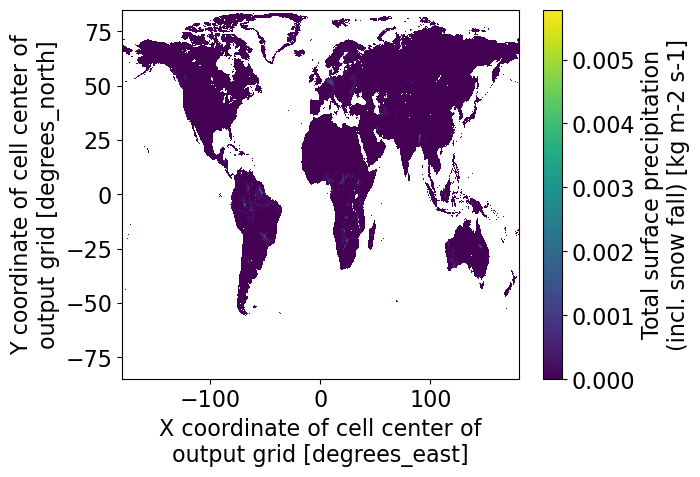

In [4]:
ds_NSIDC.precipitation_total_surface_flux.plot()

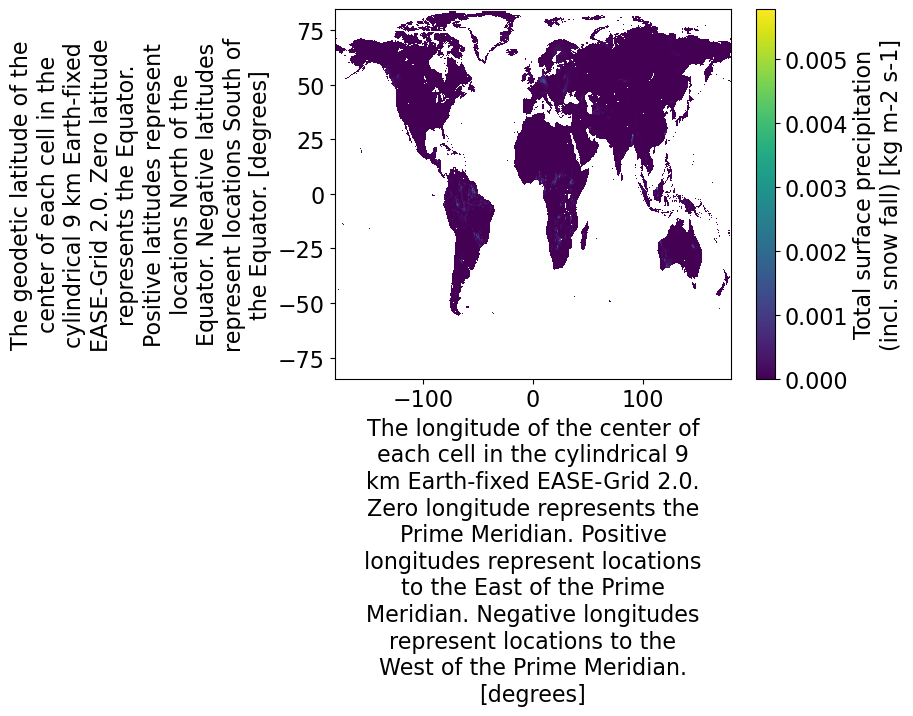

In [19]:
ds_NSIDC = ds_NSIDC.set_coords(["cell_lon", "cell_lat"])
ds_NSIDC.precipitation_total_surface_flux.plot(x="cell_lon", y="cell_lat")

- Latitude data looks okay but Precipitation data seems to be flipped along Y axis, when read with Xarray (netcdf engine)
  - Note: lat and lon information can't be read, because it is stored in different layers 
  - See this for the details: https://gis.stackexchange.com/questions/454550/error-reading-variables-from-netcdf-file-with-xarray-when-there-are-multiple-var/454643#454643


### Data reading method 2: Open data with xarray (rasterio engine)

Precipitation data is flipped along Y axis when read with rasterio

In [8]:
ds_NSIDC_rasterio = xr.open_dataset(os.path.join(input_path, fn_NSIDC_output), engine='rasterio')
ds_NSIDC_rasterio = ds_NSIDC_rasterio.set_coords(["cell_lat", "cell_lon"])
ds_NSIDC_rasterio

c:\Users\flipl\miniconda3\envs\SMAP\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\flipl\miniconda3\envs\SMAP\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.Dataset>
Dimensions:                           (band: 1, x: 3856, y: 1822)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -180.0 -179.9 ... 179.9 180.0
  * y                                 (y) float64 85.0 84.9 ... -84.92 -85.01
    projection_information            int32 ...
    cell_lat                          (band, y, x) float32 ...
    cell_lon                          (band, y, x) float32 ...
Data variables:
    cell_column                       (band, y, x) float64 ...
    cell_row                          (band, y, x) float64 ...
    precipitation_total_surface_flux  (band, y, x) float32 ...
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            
    publicationDate:                    
    title:                              
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

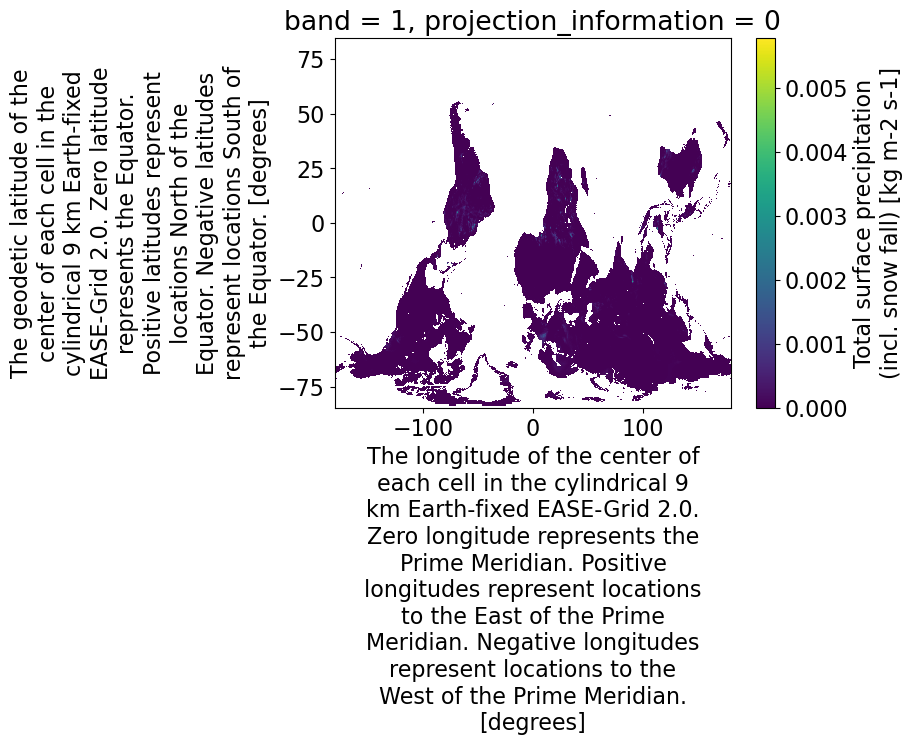

In [9]:
ds_NSIDC_rasterio.precipitation_total_surface_flux[0].plot(y="cell_lat", x="cell_lon")

### Data reading method 3: Open data with netCDF

In [10]:
ds_NSIDC_output_nc = netCDF4.Dataset(os.path.join(input_path, fn_NSIDC_output))
ds_NSIDC_output_nc['Geophysical_Data']

<class 'netCDF4._netCDF4.Group'>
group /Geophysical_Data:
    dimensions(sizes): 
    variables(dimensions): float32 precipitation_total_surface_flux(y, x)
    groups: 

In [71]:
precip = ds_NSIDC_output_nc['Geophysical_Data']['precipitation_total_surface_flux'][:]
lats = ds_NSIDC_output_nc['cell_lat'][:]
lons = ds_NSIDC_output_nc['cell_lon'][:]

Both lat & precipitation data looks good when read with netCDF

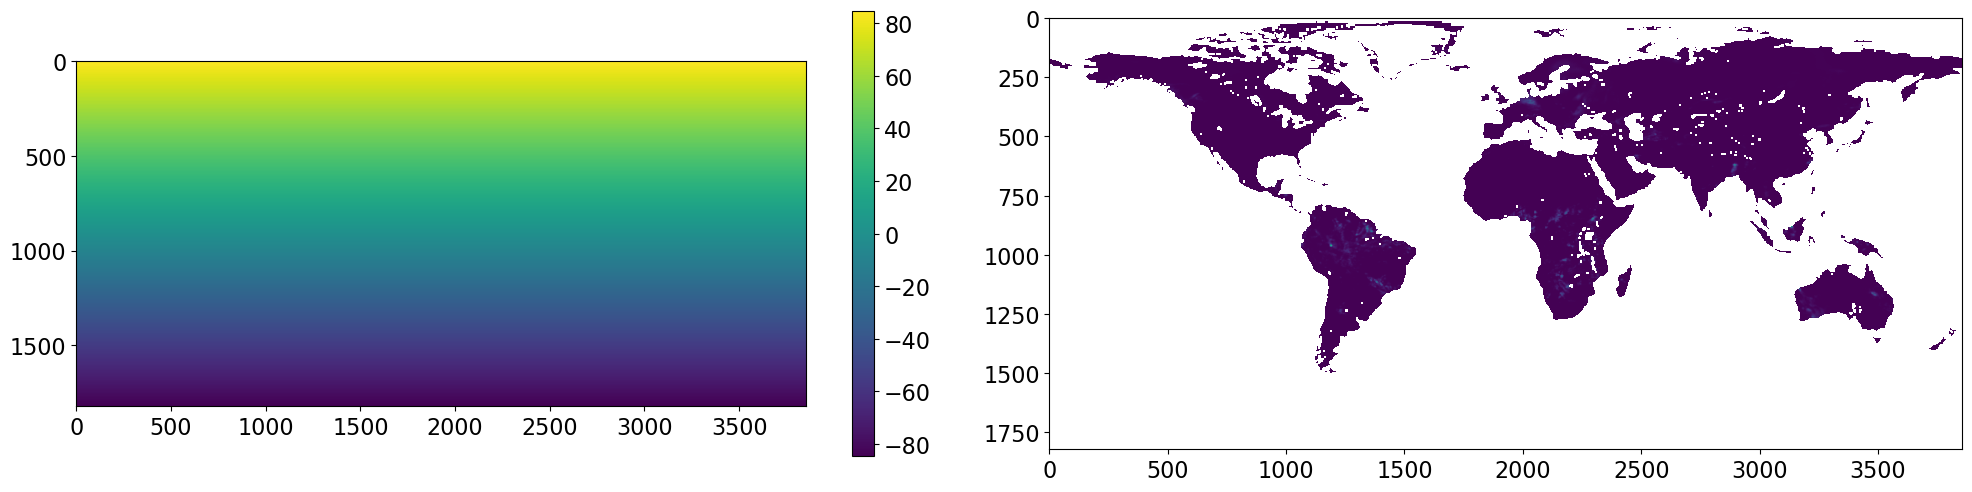

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
c = ax1.imshow(lats)
fig.colorbar(c)
ax2.imshow(precip)
fig.tight_layout()


## Input data ver 2: Original data downloaded from NASA Earth data search (no pre-processing)

- The results were the same with data input data ver 1
- Data is downloaded from Earth Data Search accessible via https://nsidc.org/data/spl4smgp/versions/7

In [77]:
fn_NASA_Earthdata_download = 'SMAP_L4_SM_gph_20150331T013000_Vv7032_001.h5'

### Data reading method 1: Open data with Xarray (auto engine)

In [78]:
ds_NASA_download = xr.open_dataset(os.path.join(input_path, fn_NASA_Earthdata_download))
ds_NASA_download

<xarray.Dataset>
Dimensions:                  (phony_dim_2: 1, y: 1624, x: 3856)
Coordinates:
  * x                        (x) float64 -1.736e+07 -1.735e+07 ... 1.736e+07
  * y                        (y) float64 7.31e+06 7.301e+06 ... -7.31e+06
Dimensions without coordinates: phony_dim_2
Data variables:
    EASE2_global_projection  (phony_dim_2) |S1 ...
    cell_column              (y, x) float64 ...
    cell_lat                 (y, x) float32 ...
    cell_lon                 (y, x) float32 ...
    cell_row                 (y, x) float64 ...
    time                     (phony_dim_2) datetime64[ns] ...
Attributes:
    Source:       v17.11.1
    Institution:  NASA Global Modeling and Assimilation Office
    History:      File written by ldas2daac.x
    Comment:      HDF-5
    Filename:     /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv7032/...
    Title:        SMAP L4_SM Geophysical (GPH) Data Granule
    Conventions:  CF
    References:   see SMAP L4_SM Product Specification Documentation
    Contact:      http://gmao.gsfc.nasa.gov

In [80]:
ds_NASA_download_precip = xr.open_dataset(os.path.join(input_path, fn_NASA_Earthdata_download), group='Geophysical_Data')
ds_NASA_download_precip.precipitation_total_surface_flux

<xarray.DataArray 'precipitation_total_surface_flux' (y: 1624, x: 3856)>
[6262144 values with dtype=float32]
Dimensions without coordinates: y, x
Attributes:
    long_name:         Total surface precipitation (incl. snow fall)
    valid_max:         0.05
    fmissing_value:    -9999.0
    DIMENSION_LABELS:  ['y', 'x']
    units:             kg m-2 s-1
    grid_mapping:      EASE2_global_projection
    coordinates:       /cell_lat /cell_lon
    valid_min:         0.0

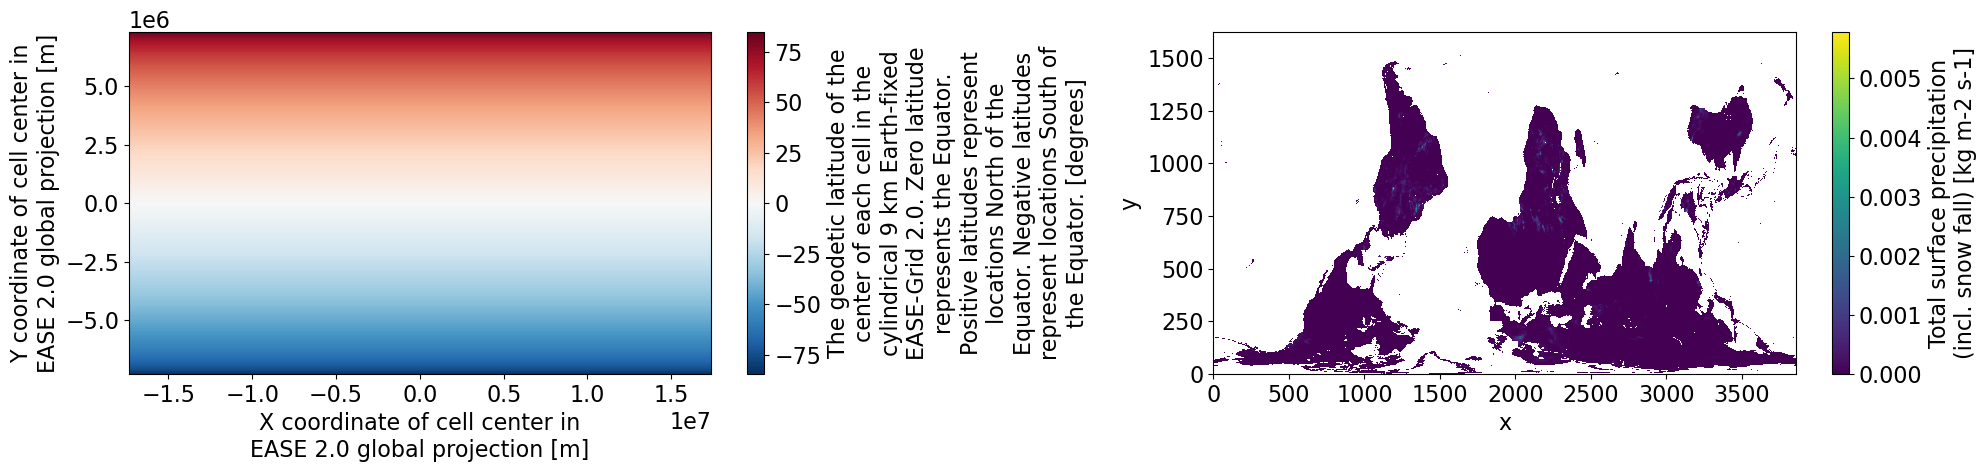

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ds_NASA_download.cell_lat.plot(ax=ax1)
ds_NASA_download_precip.precipitation_total_surface_flux.plot(ax=ax2)
fig.tight_layout()

### Data reading method 2: Open data with Xarray (rasterio engine)

In [82]:
ds_NASA_download_rasterio = xr.open_dataset(os.path.join(input_path, fn_NSIDC_output), engine='rasterio')
ds_NASA_download_rasterio

c:\Users\flipl\miniconda3\envs\SMAP\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\flipl\miniconda3\envs\SMAP\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.Dataset>
Dimensions:                           (band: 1, x: 3856, y: 1822)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -180.0 -179.9 ... 179.9 180.0
  * y                                 (y) float64 85.0 84.9 ... -84.92 -85.01
    projection_information            int32 ...
Data variables:
    cell_column                       (band, y, x) float64 ...
    cell_lat                          (band, y, x) float32 ...
    cell_lon                          (band, y, x) float32 ...
    cell_row                          (band, y, x) float64 ...
    precipitation_total_surface_flux  (band, y, x) float32 ...
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            
    publicationDate:                    
    title:                              
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

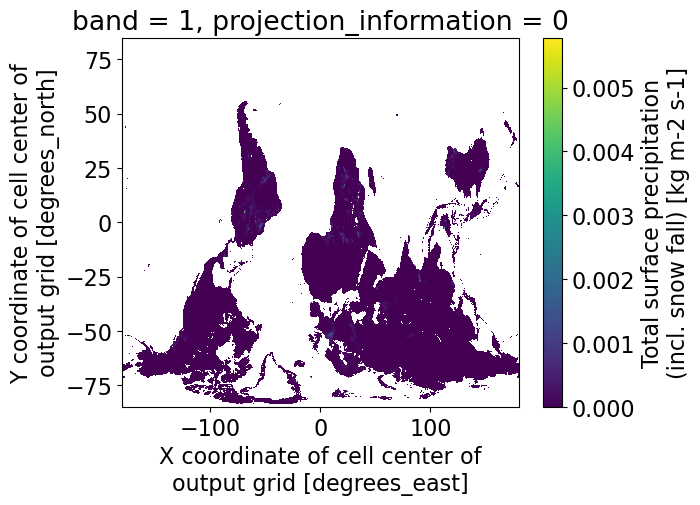

In [84]:
ds_NASA_download_rasterio.precipitation_total_surface_flux.plot()

### Data reading method 3: Open data with netcdf 

In [85]:
ds_NASA_download_nc = netCDF4.Dataset(os.path.join(input_path, fn_NASA_Earthdata_download))
ds_NASA_download_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Source: v17.11.1
    Institution: NASA Global Modeling and Assimilation Office
    History: File written by ldas2daac.x
    Comment: HDF-5
    Filename: /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv7032/gph/Y2015/M03/D31/SMAP_L4_SM_gph_20150331T013000_Vv7032_001.h5
    Title: SMAP L4_SM Geophysical (GPH) Data Granule
    Conventions: CF
    References: see SMAP L4_SM Product Specification Documentation
    Contact: http://gmao.gsfc.nasa.gov
    dimensions(sizes): x(3856), y(1624), phony_dim_2(1)
    variables(dimensions): |S1 EASE2_global_projection(phony_dim_2), uint32 cell_column(y, x), float32 cell_lat(y, x), float32 cell_lon(y, x), uint32 cell_row(y, x), float64 time(phony_dim_2), float64 x(x), float64 y(y)
    groups: Geophysical_Data, Metadata

In [86]:
ds_NASA_download_nc['Geophysical_Data']

<class 'netCDF4._netCDF4.Group'>
group /Geophysical_Data:
    dimensions(sizes): 
    variables(dimensions): float32 baseflow_flux(y, x), float32 depth_to_water_table_from_surface_in_peat(y, x), float32 free_surface_water_on_peat_flux(y, x), float32 heat_flux_ground(y, x), float32 heat_flux_latent(y, x), float32 heat_flux_sensible(y, x), float32 height_lowatmmodlay(y, x), float32 land_evapotranspiration_flux(y, x), float32 land_fraction_saturated(y, x), float32 land_fraction_snow_covered(y, x), float32 land_fraction_unsaturated(y, x), float32 land_fraction_wilting(y, x), float32 leaf_area_index(y, x), float32 mwrtm_vegopacity(y, x), float32 net_downward_longwave_flux(y, x), float32 net_downward_shortwave_flux(y, x), float32 overland_runoff_flux(y, x), float32 precipitation_total_surface_flux(y, x), float32 radiation_longwave_absorbed_flux(y, x), float32 radiation_shortwave_downward_flux(y, x), float32 sm_profile(y, x), float32 sm_profile_pctl(y, x), float32 sm_profile_wetness(y, x), fl

In [89]:
precip = ds_NASA_download_nc['Geophysical_Data']['precipitation_total_surface_flux'][:]
lats = ds_NASA_download_nc['cell_lat'][:]
lons = ds_NASA_download_nc['cell_lon'][:]

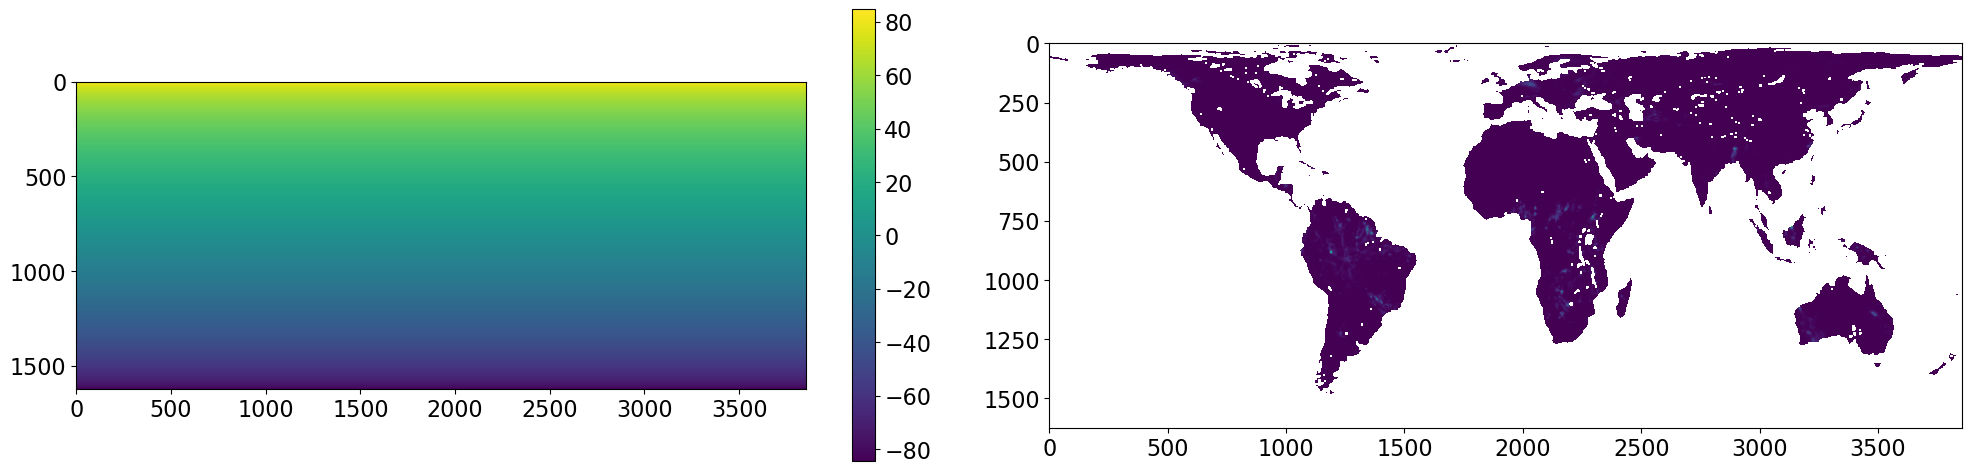

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
c = ax1.imshow(lats)
fig.colorbar(c)
ax2.imshow(precip)
fig.tight_layout()
